# MMSI 356190000 AIS Data
Shifting focus to only one MMSI in the Axial Seamount area (contains AB, EC, CC hphones). Instances found in 2016 and 2017.


## Imports

In [1]:
# data
from obspy import read as obsread
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
#import functions as fn
# plotting
#import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json
from scipy.io import wavfile

# general
from datetime import datetime
import re

from scipy.signal import welch

from geopy.distance import geodesic
import plotly.express as px
import datetime

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Functions

In [67]:
CC_node_LF = 'Central_Caldera'
EC_node_LF = 'Eastern_Caldera'
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
abdist = (45.8168, -129.7543)
def animate_map(ais, starttime, endtime):
    subais = ais[(ais['TIMESTAMP UTC'] > starttime) & (ais['TIMESTAMP UTC'] < endtime)]
    time = subais['TIMESTAMP UTC']
    for i in time:
        #subais.loc[len(subais.index)] = [0,0,'cc hydrophone'+str(i),'cc hydrophone',0,0,0, -130.0089,45.9549,0,0, i, 0,0]
        #subais.loc[len(subais.index)] = [0,0, 'cc hydrophone '+str(i), 'cc hydrophone', 0,0,0,i,0, 0,0,45.9549, -130.0089, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'cc hydrophone '+str(i), 'cc hydrophone', 0, 0, 45.9549, -130.0089, 0, 0, i, 0, 0, 0, 0]
        
        #subais.loc[len(subais.index)] = [0,0,'ec hydrophone'+str(i),'ec hydrophone',0,0,10, -129.9742,45.9399,0,0, i, 0,0]
        #subais.loc[len(subais.index)] = [0,0, 'ec hydrophone '+str(i), 'ec hydrophone', 0,0,0,i,0, 0,0,45.9399, -129.9742, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'ec hydrophone '+str(i), 'ec hydrophone', 0, 0, 45.9399, -129.9742, 0, 0, i, 0, 0, 0, 0]

        #subais.loc[len(subais.index)] = [0,0, 'ab hydrophone '+str(i), 'ab hydrophone', 0,0,0,i,0, 0,0,45.8168, -129.7543, 0, 0,0,0,0,0,0]
        subais.loc[len(subais.index)] = [0, 'ab hydrophone '+str(i), 'ab hydrophone', 0, 0, 45.8168, -129.7543, 0, 0, i, 0, 0, 0, 0]
    subais = subais.reset_index()
    for i in range(len(subais)):
        subais.loc[i,'TIMESTAMP UTC'] = subais.iloc[i]['TIMESTAMP UTC']- datetime.timedelta(minutes=subais.iloc[i]['TIMESTAMP UTC'].minute % 10)
    subais['TIMESTAMP UTC'] = subais['TIMESTAMP UTC'].dt.to_period('T')
    fig = px.scatter_mapbox(subais,
              lat="LAT" ,
              lon="LON",
              hover_name="VESSEL TYPE",
              hover_data= ['SPEED (KNOTSx10)','ccdist'],
              color="SHIPNAME",
              animation_frame=subais['TIMESTAMP UTC'].astype(dtype=str),
              mapbox_style='carto-positron',                 
              zoom=5)
    fig.show()

def get_PSD_dict(meta_data_CSV_path, location, close_distance=False):
    """
    Generate a dictionary that holds PSD data
    Ex. psd_dict[ship_type][freq_values] # not actual key names
    This data gets passed into the spdf generation and plotting functions
    
    Parameters
    ----------
    meta_data_CSV_path : str
        A file path that points to the .csv that contains the metadata. 
        Mainly used to group based on ship type (ud_group). Also matches instance_id
        to corresponding ship type.

    location : str
        String containing location of the hydrophone (i.e. Axial_Base).
        Used for file pathing

    Returns
    -------
    dict: a nested dictionary for ship type and their respective PSD data
    """

    df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)

    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group']).groupby('ud_group')

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_obj_list = []
        PSD_freq = []
        PSD_val = []
        dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
            # try-except deals with missing pickles
            try:
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                #print("Could not find pkl")
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

# function pulled from https://github.com/Ocean-Data-Lab/Website-backend     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'
    #plt.savefig(filepath+shipType+'.jpg', format='jpg')
    plt.savefig(filepath+title+'.jpg', format='jpg')
    plt.close() # suppress plotting

def get_PSD_dict_given_filt_df(df, location, close_distance=False):
    df = df.reset_index(drop=True)
    """df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)"""

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSD_obj_list = []
    PSD_freq = []
    PSD_val = []
    dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

    # for-loop to compile list of PSD data objects pulled from column
    for row_index, row in df.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        # get pickle files (DL locally? Call some API?)
        # local storage method
        data_path = 'data/' + location + '/'
        pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.json'
        #if (location == 'Eastern_Caldera'):
        #    pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
        # try-except deals with missing pickles
        try:
            print(pklfilepath)
            with open(pklfilepath, 'rb') as f:
                dict1 = json.load(f)
            #print("----------PKL FOUND----------")
            # create PSD object and fill out PSD object fields
            psd = ooipy.Psd(dict1['f'], dict1['psd'])
            dictPSD['objects'].append(psd)
            dictPSD['frequencies'].append(psd.freq)
            dictPSD['values'].append(psd.values)
        except FileNotFoundError:
            #print("Could not find pkl")
            #pass
            try:
                pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                pass
    #PSDs.update({group_name: dictPSD})
    return dictPSD

def Rx_level_from_df(df,location):

    """
    Requires dataframe for specific MMSI and maybe filtered to be sufficiently close to hydrophone.

    Return lists that contain range values (closest to farthest) within a set range (df param should already be filtered),
    and a list that contains the receive level, which is calculated from the FFT of the time series data.
    Due to needing the time series data, may be time-consuming to run.
    This data can be used to get source levels by adding/making up from Tx loss using a separate function.

    Parameters
    ----------
    df : Pandas dataframe
        A dataframe that is filtered to only contain one MMSI. Should probably also be close to hydrophone.

    Returns
    -------
    R : a list of range values in kilometers. When using it for Tx loss, need to make it an array and *1000 to get meters.

    Rx_level : a list of receive levels


    """

    df = df.sort_values(by=['distance(in km)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    R = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            R.append(df['distance(in km)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return R, Rx_level

def Rx_level_from_df_SPEED(df,location):

    df = df.sort_values(by=['SPEED (KNOTSx10)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    S = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            # Guerra_Thode_et al_2011
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            S.append(df['SPEED (KNOTSx10)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return S, Rx_level

Tx_loss1 = lambda x: 20*np.log10(x*1000)
#Tx_loss2 = lambda x: 20*np.log10(3*1000)+10*np.log10((x*1000)/(3*1000))

def Tx_loss2(x, location):
    depth_dict = {
            "AB": 3,
            "EC": 1.5,
            "CC": 1.5,
            "OS": 3,
            "SH": 0.8
        }
    return 20*np.log10(depth_dict[location]*1000)+10*np.log10((x*1000)/(depth_dict[location]*1000))

def split_10m(df):
    df = df.reset_index(drop=True)
    df['start_time'] = pd.to_datetime(np.zeros(len(df)))
    df['end_time'] = pd.to_datetime(np.zeros(len(df)))
    df['TIMESTAMP UTC'] = pd.to_datetime(df['TIMESTAMP UTC'])
    df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
    df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)
    for index, row in df[1:].iterrows():
        curr_time = row['TIMESTAMP UTC']
        prev_start = df.iloc[index-1]['start_time']
        prev_end = df.iloc[index-1]['end_time']
        if curr_time > prev_end:
            #row['start_time'] = curr_time
            df.at[index, 'start_time'] = curr_time
            #row['end_time'] = curr_time + datetime.timedelta(minutes=10)
            df.at[index, 'end_time'] = curr_time + datetime.timedelta(minutes=10)
        elif curr_time < prev_end:
            #row['start_time'] = prev_start
            df.at[index, 'start_time'] = prev_start
            #row['end_time'] = prev_end
            df.at[index, 'end_time'] = prev_end
    return df

def DL_Mseed_for_time_filtered_file(ais, start, end, verbose=False, node_override=None):
    """
    Inteded to work with ais dataframe with columns 'MMSI', 'SHIPNAME', 'VESSEL TYPE', 'STATUS', 'SPEED (KNOTSx10)', 'LAT',
       'LON', 'COURSE', 'HEADING', 'TIMESTAMP UTC', 'LENGTH', 'start_time',
       'end_time', 'ecdist', 'ccdist', 'abdist', 'closest hphone'
    """
    
    ais = ais[(ais['TIMESTAMP UTC'] >= start) & (ais['TIMESTAMP UTC'] <= end)]

    xxdist_to_node_dict = {
        'abdist' : "AB",
        'ecdist' : "EC",
        'ccdist' : "CC",
        'AB' : 'Axial_Base',
        'EC' : 'Eastern_Caldera',
        'CC' : 'Central_Caldera'
    }

    times = {
        'start_time': ais['start_time'],
        'end_time': ais['end_time'],
        'node' : ais['closest hphone']
    }
    times = pd.DataFrame(times)
    times.drop_duplicates(subset=['start_time', 'end_time', 'node'], inplace=True)

    for index, row in times.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']
        str_starttime=start_time.strftime("%Y%m%d%H%M%S")
        str_endtime=end_time.strftime("%Y%m%d%H%M%S")
        node = xxdist_to_node_dict[row['node']]
        if node_override != None:
            node = node_override
        mseed_filename = 'data/AIS/Mseed/'+str(node)+'_'
        psd_pickle_filename = 'data/AIS/PSD_pickles/' + str(node)+'_'
        data_trace = ooipy.get_acoustic_data_LF(start_time, end_time, xxdist_to_node_dict[node], verbose=False, zero_mean=True)
        print(data_trace)
        if data_trace==None:
            print('data trace is none. Continuing to next')
            pass
        else:
            data_trace.write(mseed_filename+str_starttime+'_'+str_endtime+'.mseed', format='MSEED')
            if verbose:
                print('saving '+mseed_filename+str_starttime+'_'+str_endtime+'.mseed')
            try:
                psd = data_trace.compute_psd_welch(L = 256, overlap=0.3)
                psd.save(filename=psd_pickle_filename+str_starttime+'_'+str_endtime+'.json')
            except TypeError:
                print('could not compute psd for above data trace. Continuing to next')
                pass

def add_hphone_dist(ais):
    abdist = (45.8168, -129.7543)
    ecdist = (45.9399, -129.9742)
    ccdist = (45.9549, -130.0089)
    ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]
    ais['closest hphone'] = ais[['ecdist', 'ccdist', 'abdist']].idxmin(axis=1)
    return ais

## Work

In [23]:
ais2016a = pd.read_csv('data/AIS/2016A - Updated.csv', delimiter=',')
ais2016b = pd.read_csv('data/AIS/2016B - Updated.csv', delimiter=',')
ais2017a = pd.read_csv('data/AIS/2017A - Updated.csv', delimiter=',')
ais2017b = pd.read_csv('data/AIS/2017B - Updated.csv', delimiter=',')
MMSI = 356190000
spectrogram_times = {
    'EC' : ['2017-07-27 07:13:10', '2017-07-27 08:07:23'],
    'CC' : ['2017-07-27 04:02:56', '2017-07-27 08:07:23'],
    'AB' : ['2017-08-17 03:22:52', '2017-08-17 05:37:51']
}

In [76]:
ais = pd.concat([ais2016a, ais2016b, ais2017a, ais2017b], axis=0)

In [77]:
df = ais[ais['MMSI'] == MMSI]#.reset_index(drop=True)
df

,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH
51516,356190000,PANTERA ROSA,Bulk Carrier,0,144,44.93581,-129.7273,78,74,2016-11-15 22:03:35,225.0
51523,356190000,PANTERA ROSA,Bulk Carrier,0,139,44.96260,-129.6014,71,71,2016-11-15 22:27:29,225.0
51526,356190000,PANTERA ROSA,Bulk Carrier,0,136,44.96832,-129.5753,73,70,2016-11-15 22:32:30,225.0
51531,356190000,PANTERA ROSA,Bulk Carrier,0,137,45.00777,-129.3981,71,70,2016-11-15 23:06:10,225.0
51539,356190000,PANTERA ROSA,Bulk Carrier,0,123,45.04543,-129.2250,72,70,2016-11-15 23:42:03,225.0
...,...,...,...,...,...,...,...,...,...,...,...
37636,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.60880,-130.8140,283,284,2017-10-30 08:05:06,225.0
37644,356190000,PANTERA ROSA,Bulk Carrier,0,113,46.63559,-130.9723,282,284,2017-10-30 08:40:29,225.0
37652,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.64405,-131.0218,282,284,2017-10-30 08:51:38,225.0
37671,356190000,PANTERA ROSA,Bulk Carrier,0,116,46.66926,-131.1685,284,287,2017-10-30 09:24:07,225.0


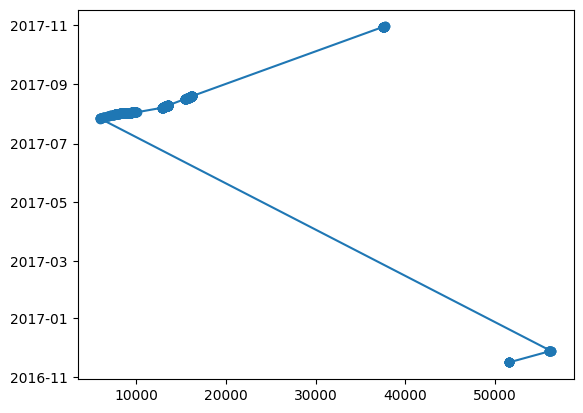

In [8]:
plt.plot(pd.to_datetime(df['TIMESTAMP UTC']), marker='o')

### AIS Mapping

In [12]:
ais = df

abdist = (45.8168, -129.7543)
ecdist = (45.9399, -129.9742)
ccdist = (45.9549, -130.0089)
ais['ecdist'] = [geodesic((a, b), ecdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['ccdist'] = [geodesic((a, b), ccdist).miles for a, b in ais[['LAT', 'LON']].values]
ais['abdist'] = [geodesic((a, b), abdist).miles for a, b in ais[['LAT', 'LON']].values]

ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC']).dt.strftime('%Y-%m-%d %H:%M:%S')
ais['TIMESTAMP UTC'] = pd.to_datetime(ais['TIMESTAMP UTC'])

animate_map(ais, '2016-11-15 22:03:35', '2017-10-30 09:43:48')

c:\Users\UserALai\miniconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Checking AIS Data
Find a suitable time frame, interpolate data as needed, find closest hphone, break into ten minute chunks, query OOI, save Mseed, get rx level


(array([437., 432., 428., 428., 429., 434., 434., 426., 428., 429.]),
 array([   0. ,  425.6,  851.2, 1276.8, 1702.4, 2128. , 2553.6, 2979.2,
        3404.8, 3830.4, 4256. ]),
 <BarContainer object of 10 artists>)

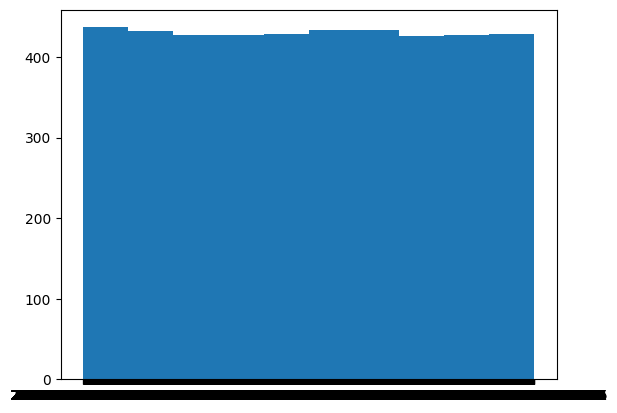

In [9]:
# this block is for finding which timeframe is most "data-dense"

# choose this timeframe? Seems most dense
df = ais[(ais['TIMESTAMP UTC'] > '2017-07-29 22:03:35') & (ais['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
#df = ais[(ais['TIMESTAMP UTC'] > '2017-08-02 00:03:35') & (ais['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
plt.hist(df['TIMESTAMP UTC'])
#plt.ylim(0, 10)

In [78]:
df

,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH
51516,356190000,PANTERA ROSA,Bulk Carrier,0,144,44.93581,-129.7273,78,74,2016-11-15 22:03:35,225.0
51523,356190000,PANTERA ROSA,Bulk Carrier,0,139,44.96260,-129.6014,71,71,2016-11-15 22:27:29,225.0
51526,356190000,PANTERA ROSA,Bulk Carrier,0,136,44.96832,-129.5753,73,70,2016-11-15 22:32:30,225.0
51531,356190000,PANTERA ROSA,Bulk Carrier,0,137,45.00777,-129.3981,71,70,2016-11-15 23:06:10,225.0
51539,356190000,PANTERA ROSA,Bulk Carrier,0,123,45.04543,-129.2250,72,70,2016-11-15 23:42:03,225.0
...,...,...,...,...,...,...,...,...,...,...,...
37636,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.60880,-130.8140,283,284,2017-10-30 08:05:06,225.0
37644,356190000,PANTERA ROSA,Bulk Carrier,0,113,46.63559,-130.9723,282,284,2017-10-30 08:40:29,225.0
37652,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.64405,-131.0218,282,284,2017-10-30 08:51:38,225.0
37671,356190000,PANTERA ROSA,Bulk Carrier,0,116,46.66926,-131.1685,284,287,2017-10-30 09:24:07,225.0


#### Splitting into 10min chunks

In [79]:
#df = df[(df['TIMESTAMP UTC'] > '2017-07-29 22:03:35') & (df['TIMESTAMP UTC'] < '2017-08-03 22:03:35')]
ais = split_10m(df)
#ais = add_hphone_dist(ais)


ais



C:\Users\UserALai\AppData\Local\Temp\ipykernel_2332\704785997.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['start_time'] = df.iloc[0:1]['TIMESTAMP UTC']
C:\Users\UserALai\AppData\Local\Temp\ipykernel_2332\704785997.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:1]['end_time'] = df.iloc[0:1]['start_time'] + datetime.timedelta(minutes=10)


,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH,start_time,end_time
0,356190000,PANTERA ROSA,Bulk Carrier,0,144,44.93581,-129.7273,78,74,2016-11-15 22:03:35,225.0,2016-11-15 22:03:35,2016-11-15 22:13:35
1,356190000,PANTERA ROSA,Bulk Carrier,0,139,44.96260,-129.6014,71,71,2016-11-15 22:27:29,225.0,2016-11-15 22:27:29,2016-11-15 22:37:29
2,356190000,PANTERA ROSA,Bulk Carrier,0,136,44.96832,-129.5753,73,70,2016-11-15 22:32:30,225.0,2016-11-15 22:27:29,2016-11-15 22:37:29
3,356190000,PANTERA ROSA,Bulk Carrier,0,137,45.00777,-129.3981,71,70,2016-11-15 23:06:10,225.0,2016-11-15 23:06:10,2016-11-15 23:16:10
4,356190000,PANTERA ROSA,Bulk Carrier,0,123,45.04543,-129.2250,72,70,2016-11-15 23:42:03,225.0,2016-11-15 23:42:03,2016-11-15 23:52:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.60880,-130.8140,283,284,2017-10-30 08:05:06,225.0,2017-10-30 08:05:06,2017-10-30 08:15:06
585,356190000,PANTERA ROSA,Bulk Carrier,0,113,46.63559,-130.9723,282,284,2017-10-30 08:40:29,225.0,2017-10-30 08:40:29,2017-10-30 08:50:29
586,356190000,PANTERA ROSA,Bulk Carrier,0,114,46.64405,-131.0218,282,284,2017-10-30 08:51:38,225.0,2017-10-30 08:51:38,2017-10-30 09:01:38
587,356190000,PANTERA ROSA,Bulk Carrier,0,116,46.66926,-131.1685,284,287,2017-10-30 09:24:07,225.0,2017-10-30 09:24:07,2017-10-30 09:34:07


In [72]:
ais['end_time'].nunique()

320

#### Iterate through again and save Mseeds

In [34]:
xxdist_to_node_dict = {
    'abdist' : "AB",
    'ecdist' : "EC",
    'ccdist' : "CC",
    'AB' : 'Axial_Base',
    'EC' : 'Eastern_Caldera',
    'CC' : 'Central_Caldera'
}

times = {
    'start_time': ais['start_time'],
    'end_time': ais['end_time'],
    'node' : ais['closest hphone']
}
times = pd.DataFrame(times)
times.drop_duplicates(subset=['start_time', 'end_time', 'node'], inplace=True)

for index, row in times.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    str_starttime=start_time.strftime("%Y%m%d%H%M%S")
    str_endtime=end_time.strftime("%Y%m%d%H%M%S")
    node = xxdist_to_node_dict[row['node']]
    mseed_filename = 'data/AIS/Mseed/'+str(node)+'_'
    psd_pickle_filename = 'data/AIS/PSD_pickles/' + str(node)+'_'
    data_trace = ooipy.get_acoustic_data_LF(start_time, end_time, xxdist_to_node_dict[node], verbose=False, zero_mean=True)
    print(data_trace)
    if data_trace==None:
        print('data trace is none. Continuing to next')
        pass
    else:
        data_trace.write(mseed_filename+str_starttime+'_'+str_endtime+'.mseed', format='MSEED')
        try:
            psd = data_trace.compute_psd_welch(L = 256, overlap=0.3)
            psd.save(filename=psd_pickle_filename+str_starttime+'_'+str_endtime+'.json')
        except TypeError:
            print('could not compute psd for above data trace. Continuing to next')
            pass



IndentationError: expected an indented block (84781009.py, line 41)

In [52]:
# getting mseeds for time frame from spectrogram using AIS data

for node, times in spectrogram_times.items():
    print(node)
    print(times)
    start = times[0]
    end = times[1]
    if node == 'EC':
        DL_Mseed_for_time_filtered_file(ais, start, end, verbose=True, node_override=node)
    else:
        DL_Mseed_for_time_filtered_file(ais, start, end, verbose=True)

EC
['2017-07-27 07:13:10', '2017-07-27 08:07:23']
OO.AXEC2.AXEC2.HDH | 2017-07-27T07:13:10.000000Z - 2017-07-27T07:23:10.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727071310_20170727072310.mseed
OO.AXEC2.AXEC2.HDH | 2017-07-27T08:07:23.000000Z - 2017-07-27T08:17:23.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/EC_20170727080723_20170727081723.mseed
CC
['2017-07-27 04:02:56', '2017-07-27 08:07:23']
OO.AXCC1.AXCC1.HDH | 2017-07-27T04:02:56.000000Z - 2017-07-27T04:12:56.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727040256_20170727041256.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T05:37:24.000000Z - 2017-07-27T05:47:24.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727053724_20170727054724.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T06:22:24.000000Z - 2017-07-27T06:32:24.000000Z | 200.0 Hz, 120001 samples
saving data/AIS/Mseed/CC_20170727062224_20170727063224.mseed
OO.AXCC1.AXCC1.HDH | 2017-07-27T07:13:10.000000Z - 2017-07-27T07:

### EC Timeframe

In [228]:
EC_timeframe = ais[(ais['TIMESTAMP UTC'] >= pd.to_datetime(spectrogram_times['EC'][0]) - datetime.timedelta(hours=3)) & (ais['TIMESTAMP UTC'] <= pd.to_datetime(spectrogram_times['EC'][1]) + datetime.timedelta(hours=3))]
EC_timeframe

,MMSI,SHIPNAME,VESSEL TYPE,STATUS,SPEED (KNOTSx10),LAT,LON,COURSE,HEADING,TIMESTAMP UTC,LENGTH,start_time,end_time
24,356190000,PANTERA ROSA,Bulk Carrier,2,7,45.99192,-130.0131,160,221,2017-07-27 05:37:24,225.0,2017-07-27 05:37:24,2017-07-27 05:47:24
25,356190000,PANTERA ROSA,Bulk Carrier,2,8,45.98133,-130.0073,160,227,2017-07-27 06:22:24,225.0,2017-07-27 06:22:24,2017-07-27 06:32:24
26,356190000,PANTERA ROSA,Bulk Carrier,2,9,45.96893,-129.9992,158,220,2017-07-27 07:13:10,225.0,2017-07-27 07:13:10,2017-07-27 07:23:10
27,356190000,PANTERA ROSA,Bulk Carrier,2,10,45.95338,-129.9934,173,217,2017-07-27 08:07:23,225.0,2017-07-27 08:07:23,2017-07-27 08:17:23
28,356190000,PANTERA ROSA,Bulk Carrier,2,2,45.92411,-129.9866,143,213,2017-07-27 10:40:21,225.0,2017-07-27 10:40:21,2017-07-27 10:50:21


In [230]:
def ten_min_interp(df):
    #interpolated_data = []
    new_timestamps = []

    # create intermediary timestamps at 10m1s intervals to avoid all having the same start time
    for idx, row in df[:-1].iterrows():
        #print(idx)
        curr_time = pd.to_datetime(row['TIMESTAMP UTC'])
        start_time = pd.to_datetime(row['start_time'])
        end_time = pd.to_datetime(row['end_time'])
        #next_time = pd.to_datetime(blah.iloc[idx+1]['TIMESTAMP UTC'])
        next_time = pd.to_datetime(df.at[idx+1, 'TIMESTAMP UTC'])
        #print(f'curr: {curr_time}, next: {next_time}')
        range_time = (pd.date_range(start=curr_time, end=next_time, freq='601S'))
        #print(range_time)
        new_timestamps.append(range_time)

    # interpolated times to add (includes existing timestamps)
    new_timestamps = new_timestamps[0].union_many(new_timestamps[1:])

    times_dict = {'TIMESTAMP UTC' : new_timestamps}
    #interpolated_data.append(pd.DataFrame(times_dict))
    #result_df = pd.concat(interpolated_data, ignore_index=True)
    #result_df
    #blah = pd.merge(df, result_df, on='TIMESTAMP UTC', how='outer')

    # merge/join interpolated data and existing rows
    interp_df = pd.merge(df, pd.DataFrame(times_dict), on='TIMESTAMP UTC', how='outer')
    # sort all real and interpolated rows based on timestamp so we can create start/end times
    interp_df_10m = split_10m(interp_df.sort_values('TIMESTAMP UTC'))

    # interpolate LAT/LON/Speed, put back in some other data
    interp_df_10m['LAT'] = interp_df_10m['LAT'].interpolate(method='linear')
    interp_df_10m['LON'] = interp_df_10m['LON'].interpolate(method='linear')
    interp_df_10m['SPEED (KNOTSx10)'] = interp_df_10m['SPEED (KNOTSx10)'].interpolate(method='linear')
    interp_df_10m['MMSI'] = interp_df_10m.iloc[0]['MMSI']
    interp_df_10m['SHIPNAME'] = interp_df_10m.iloc[0]['SHIPNAME']
    interp_df_10m['VESSEL TYPE'] = interp_df_10m.iloc[0]['VESSEL TYPE']
    interp_df_10m['LENGTH'] = interp_df_10m.iloc[0]['LENGTH']
    return interp_df_10m